In [25]:
import os
import cv2
import numpy as np
from pathlib import Path
from PIL import Image, ExifTags
from retinaface import RetinaFace
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
# Path dataset raw
RAW_TRAIN = Path("../data/Train")
RAW_VAL   = Path("../data/val")

# Path dataset processed
PROC_TRAIN = Path("../data/processed/Train")
PROC_VAL   = Path("../data/processed/val")

# Buat folder output jika belum ada
PROC_TRAIN.mkdir(parents=True, exist_ok=True)
PROC_VAL.mkdir(parents=True, exist_ok=True)

print("RAW Train :", RAW_TRAIN)
print("RAW Val   :", RAW_VAL)
print("Processed Train :", PROC_TRAIN)
print("Processed Val   :", PROC_VAL)

RAW Train : ..\data\Train
RAW Val   : ..\data\val
Processed Train : ..\data\processed\Train
Processed Val   : ..\data\processed\val


In [27]:
valid_ext = [".jpg", ".jpeg", ".png", ".jfif"]

# Ambil kelas dari Train
classes = sorted([d.name for d in RAW_TRAIN.iterdir() if d.is_dir()])
print("Jumlah kelas:", len(classes))
print(classes)

# Ambil sample image
sample_class = classes[0]
sample_dir   = RAW_TRAIN / sample_class
sample_images = [p for p in sample_dir.iterdir() if p.suffix.lower() in valid_ext]

sample_image_path = sample_images[0]
print("Sample image:", sample_image_path)


Jumlah kelas: 70
['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar', 'Alief Fathur Rahman', 'Arkan Hariz Chandrawinata Liem', 'Bayu Ega Ferdana', 'Bayu Prameswara Haris', 'Bezalel Samuel Manik', 'Bintang Fikri Fauzan', 'Boy Sandro Sigiro', 'Desty Ananta Purba', 'Dimas Azi Rajab Aizar', 'Dito Rifki Irawan', 'Dwi Arthur Revangga', 'Dyo Dwi Carol Bukit', 'Eden Wijaya', 'Eichal Elphindo Ginting', 'Elsa Elisa Yohana Sianturi', 'Fajrul Ramadhana Aqsa', 'Falih Dzakwan Zuhdi', 'Fathan Andi Kartagama', 'Fayyadh Abdillah', 'Femmy Aprillia Putri', 'Ferdana Al Hakim', 'Festus Mikhael', 'Fiqri Aldiansyah', 'Freddy Harahap', 'Gabriella Natalya Rumapea', 'Garland Wijaya', 'Havidz Ridho Pratama', 'Ichsan Kuntadi Baskara', 'Ikhsannudin Lathief', 'Intan Permata Sari', 'JP. Rafi Radiktya Arkan. R. AZ', 'Joshia Fernandes Sectio Purba', 'Joshua Palti Sinaga', 'Joy Daniella V', 'Joyapul Hanscalvin Panjaitan', 'Kayla Chika Lathisya', 'Kenneth Austin Wijaya', 

In [28]:
def load_with_correct_orientation(image_path):
    img = Image.open(image_path)

    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == "Orientation":
                break

        exif = img._getexif()

        if exif is not None:
            value = exif.get(orientation, None)
            if value == 3:
                img = img.rotate(180, expand=True)
            elif value == 6:
                img = img.rotate(270, expand=True)
            elif value == 8:
                img = img.rotate(90, expand=True)
    except:
        pass

    return img.convert("RGB")


In [29]:
def crop_by_landmarks(img, landmarks, output_size=224):
    # Landmark RetinaFace
    left_eye  = np.array(landmarks["left_eye"])
    right_eye = np.array(landmarks["right_eye"])
    nose      = np.array(landmarks["nose"])
    mouth_l   = np.array(landmarks["mouth_left"])
    mouth_r   = np.array(landmarks["mouth_right"])

    # Template landmark FaceNet (5-point)
    template = np.float32([
        [38.2946, 51.6963],  # left eye
        [73.5318, 51.5014],  # right eye
        [56.0252, 71.7366],  # nose
        [41.5493, 92.3655],  # left mouth
        [70.7299, 92.2041],  # right mouth
    ])

    # Scale agar sesuai output_size
    template[:, 0] *= (output_size / 112)
    template[:, 1] *= (output_size / 112)

    src = np.float32([left_eye, right_eye, nose, mouth_l, mouth_r])

    # Transformasi affine dari landmark → template
    M = cv2.estimateAffinePartial2D(src, template, method=cv2.LMEDS)[0]

    aligned = cv2.warpAffine(img, M, (output_size, output_size), borderValue=0)
    return aligned


In [30]:
def detect_and_crop_retina(image_path, save_size=224):
    # Load image + EXIF correction
    try:
        pil_img = load_with_correct_orientation(image_path)
        img_np = np.array(pil_img)
    except:
        return None

    # RetinaFace detection
    try:
        result = RetinaFace.detect_faces(img_np)
    except:
        return None

    # Tidak ada wajah
    if not isinstance(result, dict) or len(result.keys()) == 0:
        return None

    # Ambil wajah pertama
    key = list(result.keys())[0]
    face = result[key]

    if "landmarks" not in face:
        return None

    landmarks = face["landmarks"]

    # ALIGN wajah berdasarkan landmark (template-based)
    aligned_face = crop_by_landmarks(img_np, landmarks, output_size=save_size)

    # Convert ke BGR (untuk OpenCV)
    aligned_face = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)

    return aligned_face


In [31]:
img = detect_and_crop_retina(str(sample_image_path))

if img is None:
    print("❌ Wajah tidak terdeteksi.")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Aligned & Cropped RetinaFace ✓")
    plt.axis("off")
    plt.show()


❌ Wajah tidak terdeteksi.


In [12]:
img = detect_and_crop_retina(str(sample_image_path))

if img is None:
    print("Wajah tidak terdeteksi.")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Hasil crop RetinaFace (aligned & tegak)")
    plt.axis("off")
    plt.show()

25-11-28 19:50:37 - Directory C:\Users\ihyar/.deepface created
25-11-28 19:50:37 - Directory C:\Users\ihyar/.deepface/weights created
25-11-28 19:50:37 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: C:\Users\ihyar\.deepface\weights\retinaface.h5
100%|██████████| 119M/119M [16:20<00:00, 121kB/s]    


IndexError: list index out of range

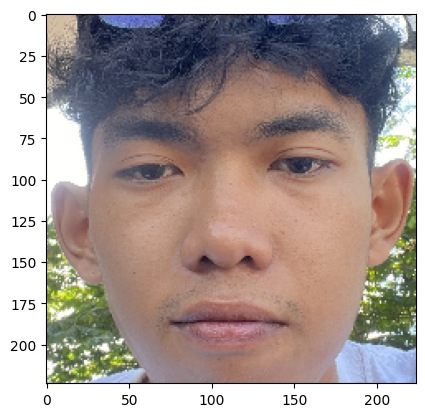

In [79]:
import cv2
import numpy as np

# Load Haar Cascade (Bawaan OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_opencv(image_path, save_size=224):
    try:
        # Load gambar biasa
        img = cv2.imread(image_path)
        if img is None: return None
        
        # Convert ke Grayscale untuk deteksi
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Deteksi Wajah
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        if len(faces) == 0:
            return None
            
        # Ambil wajah terbesar
        x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
        
        # Crop wajah
        face_img = img[y:y+h, x:x+w]
        
        # Resize ke 224x224
        face_img = cv2.resize(face_img, (save_size, save_size))
        
        return face_img

    except Exception as e:
        print(f"Error: {e}")
        return None

# Test
img = detect_and_crop_opencv(str(sample_image_path))
if img is not None:
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Wajah tidak terdeteksi")